# TEXT CLASSIFICATION WITH BLAZING TEXT

In [1]:
# ------------------------------------------------------------------------------
# DATASET SETTINGS
# ------------------------------------------------------------------------------

# Name of the CSV file you uploaded to the SageMaker Jupyter environment.
# It should be in the same directory as this notebook.
DATASET_FILE = "Restaurant_Reviews_BINARY.csv"  # Example: "customer_reviews.csv"

# List of columns that contain the text input.
# If you have more than one text column, list them in order. They will be concatenated.
TEXT_COLUMNS = ["cleaned_text_str"]  # Example: ["title", "body"], or ["feedback"]

# The name of the column that contains the labels you want to predict.
# Labels can be binary (e.g., Positive/Negative), multi-class, or numeric ratings.
LABEL_COLUMN = "Rating"  # Example: "Sentiment", "Label", "Category"

# Optional dictionary to remap label values.
# Use this if your dataset has custom labels like {"Like": "5"} or {"pos": "Positive"}.
LABEL_MAP = {
    "Like": "5"  # Modify as needed. Leave empty if no remapping is required.
}

# If known, you can set the number of unique classes (labels) in advance.
# Otherwise, leave this as None and it will be determined automatically.
NUM_CLASSES = None  # Example: 2, 3, or None

# Minimum number of samples required per class.
# Classes with fewer samples will be removed to avoid training errors.
MIN_SAMPLES_PER_CLASS = 10  # Example: 10, 20, 50

# ------------------------------------------------------------------------------
# TEXT PREPROCESSING OPTIONS
# ------------------------------------------------------------------------------

# Whether to remove common stopwords like "the", "is", "and", etc.
APPLY_STOPWORDS = True

# Whether to remove emojis, emoticons, and other non-standard symbols.
REMOVE_EMOJIS = True

# Whether to apply basic spelling correction (experimental, may slow down processing).
SPELL_CHECK = False

# ------------------------------------------------------------------------------
# CLEANUP CONFIGURATION
# ------------------------------------------------------------------------------

# If set to True, the SageMaker endpoint will be automatically deleted after testing.
# If set to False, the user will be prompted to decide.
CLEANUP = False

# ------------------------------------------------------------------------------
# SAGEMAKER AND INFRASTRUCTURE SETTINGS
# ------------------------------------------------------------------------------

# Name for the deployed endpoint. This must be unique within your AWS account.
ENDPOINT_NAME = "blazingtext-classification"  # Example: "textclassifier-john-doe"

# Instance type used for training the model.
INSTANCE_TYPE = "ml.m5.large"

# Instance type used to deploy the model for real-time inference.
DEPLOY_INSTANCE_TYPE = "ml.m5.large"

# Prefix for files stored in your S3 bucket (used internally by SageMaker).
PREFIX = "blazingtext-sentiment"


In [2]:
# Standard library imports
import os
import re
import time
import json
import logging
import string

# Third-party imports
import boto3
from botocore.exceptions import ClientError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Natural Language Processing (NLTK)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# SageMaker SDK
import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.estimator import Estimator
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

# Download required NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# SageMaker session and role
session = sagemaker.Session()
region = boto3.Session().region_name
bucket = session.default_bucket()

# Attempt to get execution role (works inside SageMaker Notebook)
try:
    role = sagemaker.get_execution_role()
    logger.info("Using SageMaker execution role.")
except Exception:
    # Fallback: attempt to get role via STS
    sts = boto3.client("sts")
    role = sts.get_caller_identity()["Arn"]
    logger.warning("Falling back to STS for role ARN.")

logger.info(f"Using role: {role}")
logger.info(f"Using bucket: {bucket}")
logger.info(f"Region: {region}")


Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/02/25 10:26:53] INFO     Found credentials from IAM Role:                                   ]8;id=404074;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=186026;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


[04/02/25 10:26:54] INFO     Found credentials from IAM Role:                                   ]8;id=685275;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=654842;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[04/02/25 10:26:55] INFO     Found credentials from IAM Role:                                   ]8;id=695772;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=75711;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Using SageMaker execution role.                                       ]8;id=536162;file:///tmp/ipykernel_9002/1809566748.py\1809566748.py]8;;\:]8;id=345001;file:///tmp/ipykernel_9002/1809566748.py#59\59]8;;\

                    INFO     Using role: arn:aws:iam::042610003076:role/LabRole                    ]8;id=903335;file:///tmp/ipykernel_9002/1809566748.py\1809566748.py]8;;\:]8;id=859145;file:///tmp/ipykernel_9002/1809566748.py#66\66]8;;\

                    INFO     Using bucket: sagemaker-us-east-1-042610003076                        ]8;id=72282;file:///tmp/ipykernel_9002/1809566748.py\1809566748.py]8;;\:]8;id=71586;file:///tmp/ipykernel_9002/1809566748.py#67\67]8;;\

                    INFO     Region: us-east-1                                                     ]8;id=18791;file:///tmp/ipykernel_9002/1809566748.py\1809566748.py]8;;\:]8;id=410635;file:///tmp/ipykernel_9002/1809566748.py#68\68]8;;\

In [3]:
# Load the dataset
try:
    df = pd.read_csv(DATASET_FILE)
    logger.info(f"Successfully loaded dataset: {DATASET_FILE}")
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file '{DATASET_FILE}' not found in current directory.")

# Preview dataset
logger.info("Dataset Preview:")
display(df.head())

# List available columns
logger.info("Available columns in dataset:")
print(df.columns.tolist())

# Check if specified columns exist
missing_columns = [col for col in TEXT_COLUMNS + [LABEL_COLUMN] if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following columns were not found in the dataset: {missing_columns}")

# Combine multiple text columns (if needed)
df["combined_text"] = df[TEXT_COLUMNS].astype(str).agg(" ".join, axis=1)

# Apply label mapping if specified
if LABEL_MAP:
    df[LABEL_COLUMN] = df[LABEL_COLUMN].replace(LABEL_MAP)

# Drop rows with missing values in key columns
initial_size = len(df)
df.dropna(subset=["combined_text", LABEL_COLUMN], inplace=True)
after_drop = len(df)
logger.info(f"Dropped {initial_size - after_drop} rows with missing text or labels.")

# Optionally convert labels to string type
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(str)

# Show class distribution before filtering
logger.info("Label distribution (before filtering):")
print(df[LABEL_COLUMN].value_counts())


                    INFO     Successfully loaded dataset: Restaurant_Reviews_BINARY.csv             ]8;id=193483;file:///tmp/ipykernel_9002/2350880736.py\2350880736.py]8;;\:]8;id=954794;file:///tmp/ipykernel_9002/2350880736.py#4\4]8;;\

                    INFO     Dataset Preview:                                                       ]8;id=842099;file:///tmp/ipykernel_9002/2350880736.py\2350880736.py]8;;\:]8;id=653549;file:///tmp/ipykernel_9002/2350880736.py#9\9]8;;\

,Rating,cleaned_text_str
0,1,ambience good food quite good saturday lunch c...
1,1,ambience good pleasant evening service prompt ...
2,1,must try great food great ambience thnx servic...
3,1,soumen da arun great guy behavior sincerety go...
4,1,food goodwe ordered kodi drumstick basket mutt...


                    INFO     Available columns in dataset:                                         ]8;id=799846;file:///tmp/ipykernel_9002/2350880736.py\2350880736.py]8;;\:]8;id=853516;file:///tmp/ipykernel_9002/2350880736.py#13\13]8;;\

['Rating', 'cleaned_text_str']


                    INFO     Dropped 0 rows with missing text or labels.                           ]8;id=477996;file:///tmp/ipykernel_9002/2350880736.py\2350880736.py]8;;\:]8;id=794362;file:///tmp/ipykernel_9002/2350880736.py#32\32]8;;\

                    INFO     Label distribution (before filtering):                                ]8;id=175490;file:///tmp/ipykernel_9002/2350880736.py\2350880736.py]8;;\:]8;id=375301;file:///tmp/ipykernel_9002/2350880736.py#38\38]8;;\

1    5949
0    3493
Name: Rating, dtype: int64


                    INFO     Classes retained (with at least 10 samples):                            ]8;id=835559;file:///tmp/ipykernel_9002/442612220.py\442612220.py]8;;\:]8;id=568455;file:///tmp/ipykernel_9002/442612220.py#7\7]8;;\

1    5949
0    3493
Name: Rating, dtype: int64


                    INFO     Number of classes inferred from data: 2                                ]8;id=415723;file:///tmp/ipykernel_9002/442612220.py\442612220.py]8;;\:]8;id=474778;file:///tmp/ipykernel_9002/442612220.py#13\13]8;;\

[04/02/25 10:26:56] INFO     Using categorical units to plot a list of strings that are all         ]8;id=584141;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=171138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=485462;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=180498;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

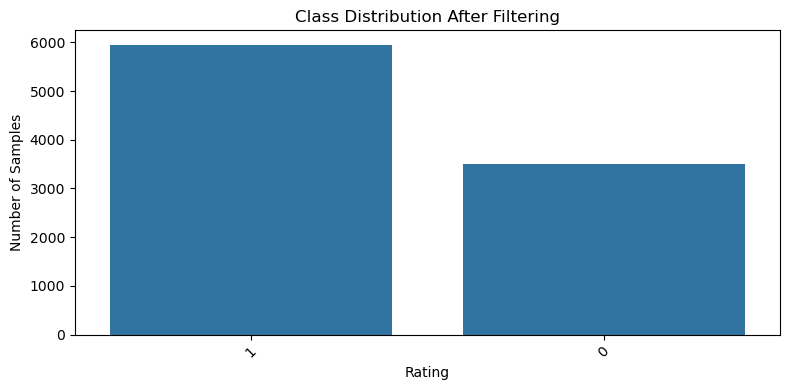

In [4]:
# Filter out classes with too few samples
class_counts = df[LABEL_COLUMN].value_counts()
valid_classes = class_counts[class_counts >= MIN_SAMPLES_PER_CLASS].index.tolist()

df = df[df[LABEL_COLUMN].isin(valid_classes)]

logger.info(f"Classes retained (with at least {MIN_SAMPLES_PER_CLASS} samples):")
print(df[LABEL_COLUMN].value_counts())

# Automatically detect number of classes if not provided
if NUM_CLASSES is None:
    NUM_CLASSES = df[LABEL_COLUMN].nunique()
    logger.info(f"Number of classes inferred from data: {NUM_CLASSES}")
else:
    logger.info(f"Number of classes defined by user: {NUM_CLASSES}")

# Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=LABEL_COLUMN, data=df, order=df[LABEL_COLUMN].value_counts().index)
plt.title("Class Distribution After Filtering")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Normalize label names for BlazingText (__label__ formatting requires clean text)
df[LABEL_COLUMN] = df[LABEL_COLUMN].str.strip().str.replace(" ", "_")


In [5]:
# Safety check: Make sure config variables are loaded
required_vars = ["SPELL_CHECK", "REMOVE_EMOJIS", "APPLY_STOPWORDS", "TEXT_COLUMNS", "LABEL_COLUMN"]
for var in required_vars:
    if var not in globals():
        raise RuntimeError(f"Configuration variable '{var}' is not defined. Please run Section 1 first.")

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")
stop_words = set(stopwords.words("english")) if APPLY_STOPWORDS else set()

# Optional: Emoji and symbol removal pattern
emoji_pattern = re.compile("[" 
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
    "]+", flags=re.UNICODE
)

# Optional: Basic spell correction using TextBlob
if SPELL_CHECK:
    try:
        from textblob import TextBlob
    except ImportError:
        raise ImportError("TextBlob is not installed. Please run: !pip install textblob")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)

    if REMOVE_EMOJIS:
        text = emoji_pattern.sub(r"", text)

    tokens = tokenizer.tokenize(text)

    if SPELL_CHECK:
        tokens = [str(TextBlob(token).correct()) for token in tokens]

    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
logger.info("Cleaning and preprocessing text...")
df["cleaned_text"] = df["combined_text"].astype(str).apply(clean_text)

# Token count statistics
df["num_tokens"] = df["cleaned_text"].apply(lambda x: len(x.split()))
logger.info("Token statistics after cleaning:")
print(df["num_tokens"].describe())

# Remove outliers based on token count
low_th, high_th = np.percentile(df["num_tokens"], [5, 95])
df = df[(df["num_tokens"] >= low_th) & (df["num_tokens"] <= high_th)]
logger.info(f"Filtered out reviews with token count outside range {low_th:.1f} to {high_th:.1f}")

# Preview cleaned samples
logger.info("Sample cleaned text:")
display(df[["cleaned_text", LABEL_COLUMN]].sample(5))


[04/02/25 10:26:57] INFO     Cleaning and preprocessing text...                                    ]8;id=34946;file:///tmp/ipykernel_9002/2330955664.py\2330955664.py]8;;\:]8;id=133809;file:///tmp/ipykernel_9002/2330955664.py#45\45]8;;\

[04/02/25 10:27:05] INFO     Token statistics after cleaning:                                      ]8;id=132806;file:///tmp/ipykernel_9002/2330955664.py\2330955664.py]8;;\:]8;id=912363;file:///tmp/ipykernel_9002/2330955664.py#50\50]8;;\

count    9442.000000
mean       21.712773
std        15.895262
min         1.000000
25%        13.000000
50%        19.000000
75%        28.000000
max        79.000000
Name: num_tokens, dtype: float64


                    INFO     Filtered out reviews with token count outside range 1.0 to 55.0       ]8;id=54595;file:///tmp/ipykernel_9002/2330955664.py\2330955664.py]8;;\:]8;id=846539;file:///tmp/ipykernel_9002/2330955664.py#56\56]8;;\

                    INFO     Sample cleaned text:                                                  ]8;id=782192;file:///tmp/ipykernel_9002/2330955664.py\2330955664.py]8;;\:]8;id=675683;file:///tmp/ipykernel_9002/2330955664.py#59\59]8;;\

,cleaned_text,Rating
8451,unprofessional unhygienic shawarma fast food s...,0
4741,point taking zomato gold many restriction elig...,0
8569,food ok service worst ever 4hrs free time spen...,0
1750,summer chill ten get know try new brew summer ...,1
4344,bad quality,0


                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=254959;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=161840;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=675392;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=344515;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

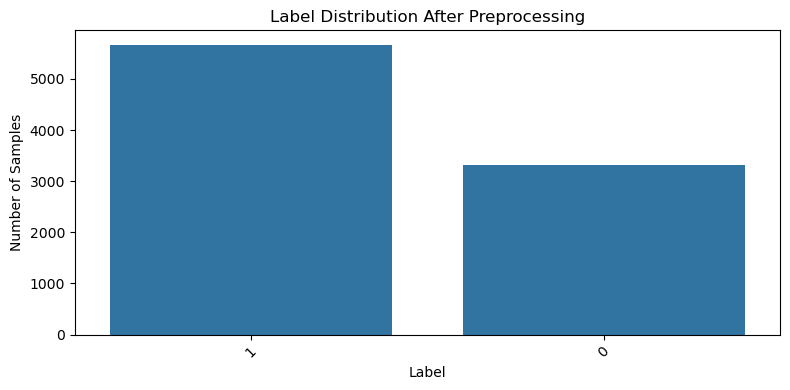

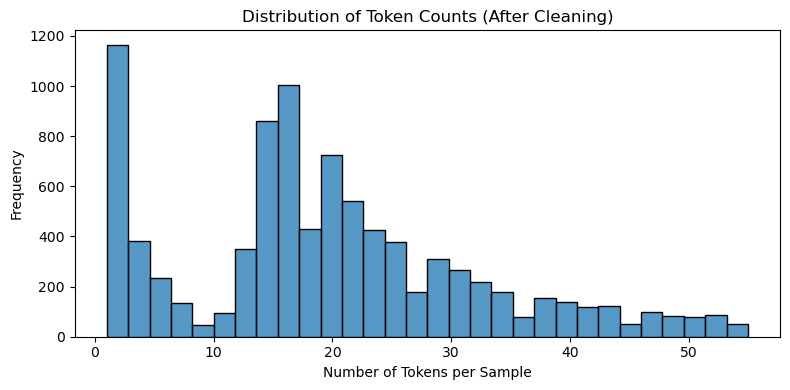

[04/02/25 10:27:06] INFO     Sample cleaned texts per label:                                       ]8;id=247182;file:///tmp/ipykernel_9002/3077917005.py\3077917005.py]8;;\:]8;id=101150;file:///tmp/ipykernel_9002/3077917005.py#21\21]8;;\


Label: 1
Example 1: simply love taste everything order place
Example 2: try many thing chicken dum biryani good quantity good single person much two people enough would need get shake something like hungry full till neckthat like eating biryani two person normal eater winwin

Label: 0
Example 1: worst ever experience booking place corporate dinner courtesy sense talk customer reservation team intention business would never ever recommend place anyone
Example 2: k baker known food bakery item ordered veg hot dog premium butter scotch pastry italian chocolate pastry veg hot dog stuffed aloo onion tomato slice mayonnaise taste good pastry also worth try overall ok


In [6]:
# Plot label distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x=LABEL_COLUMN, order=df[LABEL_COLUMN].value_counts().index)
plt.title("Label Distribution After Preprocessing")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot distribution of token counts
plt.figure(figsize=(8, 4))
sns.histplot(df["num_tokens"], bins=30, kde=False)
plt.title("Distribution of Token Counts (After Cleaning)")
plt.xlabel("Number of Tokens per Sample")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Show example cleaned texts for each label
logger.info("Sample cleaned texts per label:")
for label in df[LABEL_COLUMN].unique():
    print(f"\nLabel: {label}")
    sample_texts = df[df[LABEL_COLUMN] == label]["cleaned_text"].sample(2, random_state=42)
    for i, txt in enumerate(sample_texts, 1):
        print(f"Example {i}: {txt}")


In [7]:
logger.info("Generating text files for LDA topic modeling...")

# Create a folder to store LDA files
lda_output_folder = "lda_texts"
os.makedirs(lda_output_folder, exist_ok=True)

# Save one file per label
label_list = df[LABEL_COLUMN].unique()
for label in label_list:
    file_path = os.path.join(lda_output_folder, f"{label}_texts.txt")
    subset = df[df[LABEL_COLUMN] == label]["cleaned_text"]
    with open(file_path, "w", encoding="utf-8") as f:
        for line in subset:
            f.write(line.strip().replace("\n", " ") + "\n")
    logger.info(f"Saved: {file_path}")


                    INFO     Generating text files for LDA topic modeling...                        ]8;id=903348;file:///tmp/ipykernel_9002/3125096628.py\3125096628.py]8;;\:]8;id=781078;file:///tmp/ipykernel_9002/3125096628.py#1\1]8;;\

                    INFO     Saved: lda_texts/1_texts.txt                                          ]8;id=992297;file:///tmp/ipykernel_9002/3125096628.py\3125096628.py]8;;\:]8;id=209990;file:///tmp/ipykernel_9002/3125096628.py#15\15]8;;\

                    INFO     Saved: lda_texts/0_texts.txt                                          ]8;id=700489;file:///tmp/ipykernel_9002/3125096628.py\3125096628.py]8;;\:]8;id=464344;file:///tmp/ipykernel_9002/3125096628.py#15\15]8;;\

In [8]:
# First split: train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df[LABEL_COLUMN],
    random_state=42
)

# Second split: validation (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df[LABEL_COLUMN],
    random_state=42
)

# Report sizes
logger.info("Data split completed.")
logger.info(f"Training set size: {len(train_df)}")
logger.info(f"Validation set size: {len(val_df)}")
logger.info(f"Test set size: {len(test_df)}")

# Optional: display class distribution in each split
def show_split_distribution(name, subset):
    print(f"\n{name} class distribution:")
    print(subset[LABEL_COLUMN].value_counts())

show_split_distribution("Training", train_df)
show_split_distribution("Validation", val_df)
show_split_distribution("Test", test_df)


                    INFO     Data split completed.                                                 ]8;id=858971;file:///tmp/ipykernel_9002/3418380189.py\3418380189.py]8;;\:]8;id=968370;file:///tmp/ipykernel_9002/3418380189.py#18\18]8;;\

                    INFO     Training set size: 6287                                               ]8;id=57059;file:///tmp/ipykernel_9002/3418380189.py\3418380189.py]8;;\:]8;id=861130;file:///tmp/ipykernel_9002/3418380189.py#19\19]8;;\

                    INFO     Validation set size: 1347                                             ]8;id=690371;file:///tmp/ipykernel_9002/3418380189.py\3418380189.py]8;;\:]8;id=13156;file:///tmp/ipykernel_9002/3418380189.py#20\20]8;;\

                    INFO     Test set size: 1348                                                   ]8;id=628453;file:///tmp/ipykernel_9002/3418380189.py\3418380189.py]8;;\:]8;id=880748;file:///tmp/ipykernel_9002/3418380189.py#21\21]8;;\


Training class distribution:
1    3966
0    2321
Name: Rating, dtype: int64

Validation class distribution:
1    850
0    497
Name: Rating, dtype: int64

Test class distribution:
1    850
0    498
Name: Rating, dtype: int64


In [9]:
def create_blazingtext_file(df_subset, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df_subset.iterrows():
            label = str(row[LABEL_COLUMN]).lower().strip().replace(" ", "_")
            text = str(row["cleaned_text"]).strip().replace("\n", " ")
            if label and text:
                f.write(f"__label__{label} {text}\n")

# Create formatted files
create_blazingtext_file(train_df, "train.txt")
create_blazingtext_file(val_df, "validation.txt")
create_blazingtext_file(test_df, "test.txt")

logger.info("Formatted text files created for BlazingText:")
logger.info(" - train.txt")
logger.info(" - validation.txt")
logger.info(" - test.txt")


[04/02/25 10:27:07] INFO     Formatted text files created for BlazingText:                          ]8;id=822566;file:///tmp/ipykernel_9002/144093799.py\144093799.py]8;;\:]8;id=666108;file:///tmp/ipykernel_9002/144093799.py#14\14]8;;\

                    INFO      - train.txt                                                           ]8;id=70297;file:///tmp/ipykernel_9002/144093799.py\144093799.py]8;;\:]8;id=333037;file:///tmp/ipykernel_9002/144093799.py#15\15]8;;\

                    INFO      - validation.txt                                                      ]8;id=728966;file:///tmp/ipykernel_9002/144093799.py\144093799.py]8;;\:]8;id=727198;file:///tmp/ipykernel_9002/144093799.py#16\16]8;;\

                    INFO      - test.txt                                                            ]8;id=330909;file:///tmp/ipykernel_9002/144093799.py\144093799.py]8;;\:]8;id=852370;file:///tmp/ipykernel_9002/144093799.py#17\17]8;;\

In [10]:
# Define S3 key prefix path (subfolder)
train_key = f"{PREFIX}/train/train.txt"
val_key = f"{PREFIX}/validation/validation.txt"
test_key = f"{PREFIX}/test/test.txt"

# Upload to S3
train_s3_uri = session.upload_data(path="train.txt", bucket=bucket, key_prefix=f"{PREFIX}/train")
val_s3_uri = session.upload_data(path="validation.txt", bucket=bucket, key_prefix=f"{PREFIX}/validation")
test_s3_uri = session.upload_data(path="test.txt", bucket=bucket, key_prefix=f"{PREFIX}/test")

logger.info("Data uploaded to S3:")
logger.info(f" - Training data:    {train_s3_uri}")
logger.info(f" - Validation data: {val_s3_uri}")
logger.info(f" - Test data:       {test_s3_uri}")


                    INFO     Data uploaded to S3:                                                   ]8;id=752141;file:///tmp/ipykernel_9002/507553151.py\507553151.py]8;;\:]8;id=172183;file:///tmp/ipykernel_9002/507553151.py#11\11]8;;\

                    INFO      - Training data:                                                      ]8;id=832594;file:///tmp/ipykernel_9002/507553151.py\507553151.py]8;;\:]8;id=594995;file:///tmp/ipykernel_9002/507553151.py#12\12]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/train/trai                
                             n.txt                                                                                 

                    INFO      - Validation data:                                                    ]8;id=399729;file:///tmp/ipykernel_9002/507553151.py\507553151.py]8;;\:]8;id=826641;file:///tmp/ipykernel_9002/507553151.py#13\13]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/validation                
                             /validation.txt                                                                       

                    INFO      - Test data:                                                          ]8;id=237864;file:///tmp/ipykernel_9002/507553151.py\507553151.py]8;;\:]8;id=113045;file:///tmp/ipykernel_9002/507553151.py#14\14]8;;\
                             s3://sagemaker-us-east-1-042610003076/blazingtext-sentiment/test/test.                
                             txt                                                                                   

In [13]:
sm_client = boto3.client("sagemaker")

def delete_existing_endpoint(endpoint_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        logger.info(f"Existing endpoint found: {endpoint_name}. Deleting...")
        sm_client.delete_endpoint(EndpointName=endpoint_name)
    except ClientError:
        logger.info(f"No existing endpoint named {endpoint_name} to delete.")

    try:
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleted existing endpoint config: {endpoint_name}")
    except ClientError:
        logger.info(f"No existing endpoint config to delete for: {endpoint_name}")

    # Wait for endpoint deletion
    logger.info("Waiting for endpoint deletion to complete...")
    while True:
        try:
            status = sm_client.describe_endpoint(EndpointName=endpoint_name)
            logger.info(f"Endpoint status: {status['EndpointStatus']} — still deleting...")
            time.sleep(5)
        except ClientError as e:
            if "Could not find endpoint" in str(e):
                logger.info("Endpoint deletion confirmed.")
                break
            else:
                raise e


# Get the image URI for the BlazingText container
bt_image_uri = image_uris.retrieve("blazingtext", region=region)

# Initialize the BlazingText Estimator
bt_estimator = Estimator(
    image_uri=bt_image_uri,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    output_path=f"s3://{bucket}/{PREFIX}/output",
    sagemaker_session=session
)


# Set fixed hyperparameters that are not part of tuning
bt_estimator.set_hyperparameters(
    mode="supervised",
    min_count=2  # Minimum word count; not being tuned
)

# Define hyperparameter search space
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.01, 0.3),
    "epochs": IntegerParameter(5, 30),
    "word_ngrams": IntegerParameter(1, 2)
}

# Define objective metric and its regex pattern
objective_metric_name = "validation:accuracy"
metric_definitions = [{
    "Name": "validation:accuracy",
    "Regex": "validation accuracy=(\\S+)"
}]

# Create a HyperparameterTuner object
tuner = HyperparameterTuner(
    estimator=bt_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    objective_type="Maximize",
    max_jobs=10,
    max_parallel_jobs=2
)

# Start the hyperparameter tuning job
logger.info("Starting hyperparameter tuning job with BlazingText on SageMaker...")

tuner.fit({
    "train": TrainingInput(train_s3_uri, distribution="FullyReplicated"),
    "validation": TrainingInput(val_s3_uri, distribution="FullyReplicated")
})

# Optional: Wait for the tuning job to complete and deploy the best model
tuner.wait()

# Retrieve and deploy the best model from the tuning job
delete_existing_endpoint(ENDPOINT_NAME)

logger.info(f"Deploying the best model from hyperparameter tuning to endpoint: {ENDPOINT_NAME}")
best_estimator = tuner.best_estimator()

predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type=DEPLOY_INSTANCE_TYPE,
    endpoint_name=ENDPOINT_NAME
)

# Set up JSON serialization/deserialization for inference
predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

logger.info("Best model deployed and ready for inference.")

delete_existing_endpoint(ENDPOINT_NAME)

logger.info(f"Deploying the best model from hyperparameter tuning to endpoint: {ENDPOINT_NAME}")
best_estimator = tuner.best_estimator()

predictor = best_estimator.deploy(
    initial_instance_count=1,
    instance_type=DEPLOY_INSTANCE_TYPE,
    endpoint_name=ENDPOINT_NAME
)

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

logger.info("Best model deployed and ready for inference.")

[04/02/25 11:09:28] INFO     Same images used for training and inference. Defaulting to image     ]8;id=211041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=565295;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=770625;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=533865;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Starting hyperparameter tuning job with BlazingText on SageMaker...     ]8;id=783215;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=161821;file:///tmp/ipykernel_9002/12253089.py#78\78]8;;\

                    WARNING  No finished training job found associated with this estimator.       ]8;id=366578;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=59886;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=451998;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=89552;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name: blazingtext-250402-1109  ]8;id=889800;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=208835;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\

...................................................................................................................!
!


[04/02/25 11:19:29] INFO     Existing endpoint found: blazingtext-classification. Deleting...         ]8;id=400393;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=908746;file:///tmp/ipykernel_9002/12253089.py#6\6]8;;\

                    INFO     Deleted existing endpoint config: blazingtext-classification            ]8;id=150943;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=53603;file:///tmp/ipykernel_9002/12253089.py#13\13]8;;\

                    INFO     Waiting for endpoint deletion to complete...                            ]8;id=597508;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=637540;file:///tmp/ipykernel_9002/12253089.py#18\18]8;;\

                    INFO     Endpoint status: Deleting — still deleting...                           ]8;id=591183;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=577536;file:///tmp/ipykernel_9002/12253089.py#22\22]8;;\

[04/02/25 11:19:34] INFO     Endpoint deletion confirmed.                                            ]8;id=89827;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=418159;file:///tmp/ipykernel_9002/12253089.py#26\26]8;;\

                    INFO     Deploying the best model from hyperparameter tuning to endpoint:        ]8;id=225649;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=858772;file:///tmp/ipykernel_9002/12253089.py#91\91]8;;\
                             blazingtext-classification                                                            


2025-04-02 11:19:19 Starting - Found matching resource for reuse
2025-04-02 11:19:19 Downloading - Downloading the training image
2025-04-02 11:19:19 Training - Training image download completed. Training in progress.
2025-04-02 11:19:19 Uploading - Uploading generated training model
2025-04-02 11:19:19 Completed - Resource retained for reuse


[04/02/25 11:19:40] INFO     Creating model with name: blazingtext-2025-04-02-11-19-40-190          ]8;id=586196;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=510482;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name blazingtext-classification          ]8;id=257862;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=206988;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name blazingtext-classification                 ]8;id=469037;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=811686;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-----!

[04/02/25 11:22:42] INFO     Best model deployed and ready for inference.                           ]8;id=794570;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=596044;file:///tmp/ipykernel_9002/12253089.py#104\104]8;;\

                    INFO     Existing endpoint found: blazingtext-classification. Deleting...         ]8;id=132277;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=900716;file:///tmp/ipykernel_9002/12253089.py#6\6]8;;\

                    INFO     No existing endpoint config to delete for: blazingtext-classification   ]8;id=645368;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=854732;file:///tmp/ipykernel_9002/12253089.py#15\15]8;;\

                    INFO     Waiting for endpoint deletion to complete...                            ]8;id=16932;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=469483;file:///tmp/ipykernel_9002/12253089.py#18\18]8;;\

                    INFO     Endpoint status: Deleting — still deleting...                           ]8;id=675346;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=503230;file:///tmp/ipykernel_9002/12253089.py#22\22]8;;\

[04/02/25 11:22:47] INFO     Endpoint deletion confirmed.                                            ]8;id=441204;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=217326;file:///tmp/ipykernel_9002/12253089.py#26\26]8;;\

                    INFO     Deploying the best model from hyperparameter tuning to endpoint:       ]8;id=415426;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=203164;file:///tmp/ipykernel_9002/12253089.py#108\108]8;;\
                             blazingtext-classification                                                            


2025-04-02 11:19:19 Starting - Found matching resource for reuse
2025-04-02 11:19:19 Downloading - Downloading the training image
2025-04-02 11:19:19 Training - Training image download completed. Training in progress.
2025-04-02 11:19:19 Uploading - Uploading generated training model
2025-04-02 11:19:19 Completed - Resource retained for reuse


[04/02/25 11:22:53] INFO     Creating model with name: blazingtext-2025-04-02-11-22-53-108          ]8;id=324151;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=871408;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name blazingtext-classification          ]8;id=353257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=171206;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

[04/02/25 11:22:54] INFO     Creating endpoint with name blazingtext-classification                 ]8;id=910576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=970939;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-----!

[04/02/25 11:25:55] INFO     Best model deployed and ready for inference.                           ]8;id=591364;file:///tmp/ipykernel_9002/12253089.py\12253089.py]8;;\:]8;id=46711;file:///tmp/ipykernel_9002/12253089.py#120\120]8;;\

In [14]:
sm_client = boto3.client("sagemaker")

def delete_existing_endpoint(endpoint_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        logger.info(f"Existing endpoint found: {endpoint_name}. Deleting...")
        sm_client.delete_endpoint(EndpointName=endpoint_name)
    except ClientError:
        logger.info(f"No existing endpoint named {endpoint_name} to delete.")

    try:
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleted existing endpoint config: {endpoint_name}")
    except ClientError:
        logger.info(f"No existing endpoint config to delete for: {endpoint_name}")

    # Wait for endpoint deletion
    logger.info("Waiting for endpoint deletion to complete...")
    while True:
        try:
            status = sm_client.describe_endpoint(EndpointName=endpoint_name)
            logger.info(f"Endpoint status: {status['EndpointStatus']} — still deleting...")
            time.sleep(5)
        except ClientError as e:
            if "Could not find endpoint" in str(e):
                logger.info("Endpoint deletion confirmed.")
                break
            else:
                raise e


In [15]:
def batch_predict(predictor, texts, batch_size=100):
    """
    Sends text data in batches to the deployed endpoint and returns predicted labels.
    """
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]

        # Make prediction request
        response = predictor.predict({
            "instances": batch,
            "configuration": {"k": 1}
        })

        for result in response:
            labels = result.get("label", [])
            probs = result.get("prob", [])

            if labels and probs:
                # Extract label and remove __label__ prefix
                predicted = labels[0].replace("__label__", "").capitalize()
                predictions.append(predicted)
            else:
                predictions.append("Unknown")

    return predictions

logger.info("Running batch predictions on test set...")
test_df["predicted_label"] = batch_predict(predictor, test_df["cleaned_text"].tolist())

logger.info("Sample predictions (actual vs. predicted):")
display(test_df[[LABEL_COLUMN, "predicted_label", "cleaned_text"]].sample(5, random_state=1))


                    INFO     Running batch predictions on test set...                              ]8;id=422566;file:///tmp/ipykernel_9002/2090662569.py\2090662569.py]8;;\:]8;id=410504;file:///tmp/ipykernel_9002/2090662569.py#29\29]8;;\

                    INFO     Sample predictions (actual vs. predicted):                            ]8;id=877343;file:///tmp/ipykernel_9002/2090662569.py\2090662569.py]8;;\:]8;id=768500;file:///tmp/ipykernel_9002/2090662569.py#32\32]8;;\

,Rating,predicted_label,cleaned_text
6935,1,5,unique concept cafe hiring bike car enjoying c...
6673,1,5,staff friendly polite one best chinese restaur...
7094,1,5,good boy
1837,1,5,delivered time
156,1,5,awesome food service degraded compared last ye...


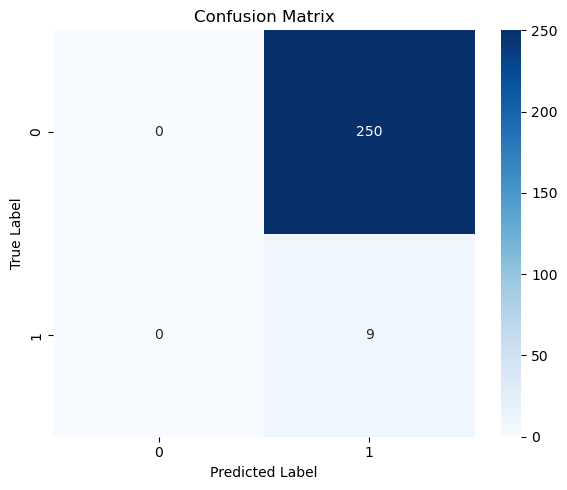

Evaluation Metrics:
 - Accuracy : 0.0067
 - Precision: 0.0219
 - Recall   : 0.0067
 - F1 Score : 0.0102

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       498
           1       0.03      0.01      0.02       850
           2       0.00      0.00      0.00         0
         2.5       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.01      1348
   macro avg       0.00      0.00      0.00      1348
weighted avg       0.02      0.01      0.01      1348



In [16]:
# Confusion matrix
labels = sorted(df[LABEL_COLUMN].unique())
cm = confusion_matrix(test_df[LABEL_COLUMN], test_df["predicted_label"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

accuracy = accuracy_score(test_df[LABEL_COLUMN], test_df["predicted_label"])
precision = precision_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)
recall = recall_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)
f1 = f1_score(test_df[LABEL_COLUMN], test_df["predicted_label"], average="weighted", zero_division=0)

print("Evaluation Metrics:")
print(f" - Accuracy : {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall   : {recall:.4f}")
print(f" - F1 Score : {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(test_df[LABEL_COLUMN], test_df["predicted_label"], zero_division=0))


In [17]:
def predict_custom_input(text_input):
    """
    Sends a single review to the deployed endpoint and returns the predicted label.
    """
    response = predictor.predict({
        "instances": [text_input],
        "configuration": {"k": 1}
    })

    if response and "label" in response[0]:
        label = response[0]["label"][0].replace("__label__", "").capitalize()
        prob = response[0]["prob"][0]
        return label, prob
    else:
        return "Unknown", 0.0

print("\nTry your own review. Type 'exit' to quit.\n")
while True:
    user_input = input("Enter a review: ").strip()
    if user_input.lower() == "exit":
        print("Exiting interactive prediction.")
        break
    if not user_input:
        continue

    predicted_label, confidence = predict_custom_input(user_input)
    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})\n")

# Optional cleanup
if CLEANUP:
    logger.info(f"Auto-cleanup enabled. Deleting endpoint: {ENDPOINT_NAME}")
    predictor.delete_endpoint()
else:
    prompt = input(f"\nDo you want to delete the endpoint '{ENDPOINT_NAME}' now? (yes/no): ").strip().lower()
    if prompt in ["yes", "y"]:
        predictor.delete_endpoint()
        logger.info("Endpoint deleted.")
    else:
        logger.info("Endpoint left running. You can delete it later to avoid charges.")



Try your own review. Type 'exit' to quit.



Enter a review:  Would definitely come back again!


Predicted Label: 5 (Confidence: 0.67)



Enter a review:  Would never come back again!


Predicted Label: 1 (Confidence: 0.98)



Enter a review:  ambience good food quite good saturday lunch cost effective good place sate brunch one also chill friend parent waiter soumen da really courteous helpful


Predicted Label: 5 (Confidence: 0.74)



Enter a review:  bad experience beyond flavour really put beyond flavour gone dinner next day get hospitalised food infection guess food served fresh


Predicted Label: 1 (Confidence: 0.77)



Enter a review:  exit


Exiting interactive prediction.



Do you want to delete the endpoint 'blazingtext-classification' now? (yes/no):  no


[04/02/25 11:43:13] INFO     Endpoint left running. You can delete it later to avoid charges.      ]8;id=7443;file:///tmp/ipykernel_9002/2219769333.py\2219769333.py]8;;\:]8;id=619095;file:///tmp/ipykernel_9002/2219769333.py#39\39]8;;\